In [1]:
from __future__ import annotations

from pathlib import Path
import gzip
import os
import random

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
)

import pandas as pd
from torchvision.models import resnet18

Подключаем библиотеки необходимые для обучения моделей,получения метрик,визуализаций итд.

In [3]:
SEED = 42

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Фиксируем seed для воспроизводимости эксперемента. 

In [5]:
ROOT = Path(".")
DATA_DIR = ROOT / "data"

IMAGES_GZ = DATA_DIR / "t10k-images-idx3-ubyte.gz"
LABELS_GZ = DATA_DIR / "t10k-labels-idx1-ubyte.gz"

IMAGES_GZ.exists(), LABELS_GZ.exists()

(True, True)

Указываем пути и проверяем наличие данных.

In [7]:
def load_mnist_images_gz(path: Path) -> np.ndarray:
    with gzip.open(path, "rb") as f:
        raw = f.read()
    arr = np.frombuffer(raw, dtype=np.uint8, offset=16)
    return arr.reshape(-1, 28, 28)


def load_mnist_labels_gz(path: Path) -> np.ndarray:
    with gzip.open(path, "rb") as f:
        raw = f.read()
    return np.frombuffer(raw, dtype=np.uint8, offset=8)

Функции для загрузки данных

In [9]:
X = load_mnist_images_gz(IMAGES_GZ).astype(np.float32)
y = load_mnist_labels_gz(LABELS_GZ).astype(np.int64)

X.shape, y.shape

((10000, 28, 28), (10000,))

Загружаем данные

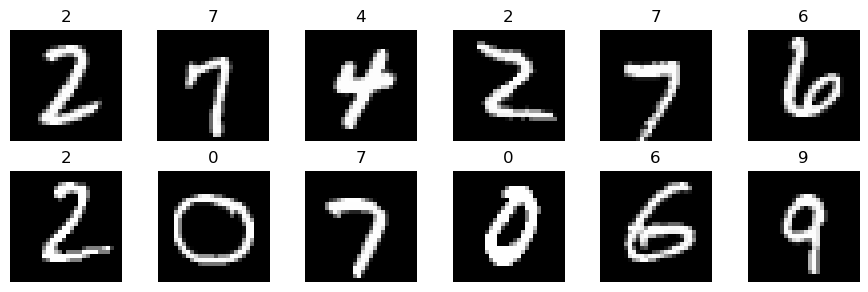

In [11]:
idx = np.random.default_rng(SEED).choice(len(X), 12, replace=False)

plt.figure(figsize=(9, 3))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 6, i)
    plt.imshow(X[k], cmap="gray")
    plt.title(int(y[k]))
    plt.axis("off")
plt.tight_layout()
plt.show()

Проверяем успех загрузки визуализируя рандомные примеры из датасета

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=SEED,
    stratify=y,
)

X_train.shape, X_test.shape

((7000, 28, 28), (3000, 28, 28))

Разбиение на train, test 70-30. Стратификация сохраняет распредление между классами.

In [15]:
np.bincount(y_train), np.bincount(y_test)

(array([686, 795, 722, 707, 687, 624, 671, 720, 682, 706]),
 array([294, 340, 310, 303, 295, 268, 287, 308, 292, 303]))

Проверка корректности распредления классов.

In [17]:
X_train_01 = X_train / 255.0
X_test_01 = X_test / 255.0

Нормализируем диапозон чтобы привести данные к стандартном виду.Это улучшает стабильность обучения нейросетей.

In [19]:
def otsu_threshold_uint8(img: np.ndarray) -> int:
    hist = np.bincount(img.ravel().astype(np.uint8), minlength=256).astype(np.float64)
    total = img.size
    p = hist / total
    omega = np.cumsum(p)
    mu = np.cumsum(p * np.arange(256))
    mu_t = mu[-1]
    denom = omega * (1.0 - omega)
    denom[denom == 0] = np.nan
    sigma_b2 = (mu_t * omega - mu) ** 2 / denom
    return int(np.nanargmax(sigma_b2))


def segment_otsu(img01: np.ndarray) -> np.ndarray:
    img255 = (img01 * 255.0).astype(np.uint8)
    t = otsu_threshold_uint8(img255)
    return (img255 > t).astype(np.float32)


def segment_batch(X01: np.ndarray) -> np.ndarray:
    return np.stack([segment_otsu(im) for im in X01], axis=0)

Выбираем Otsu thresholding как классический метод сегментации, потому-что он автоматически подбирает порог по гистограмме яркостей, не требует ручной настройки и хорошо подходит для задачи сегментации.

In [21]:
X_train_seg = segment_batch(X_train_01)
X_test_seg = segment_batch(X_test_01)

X_train_seg.shape, X_test_seg.shape

((7000, 28, 28), (3000, 28, 28))

Применение сегментации к train и test

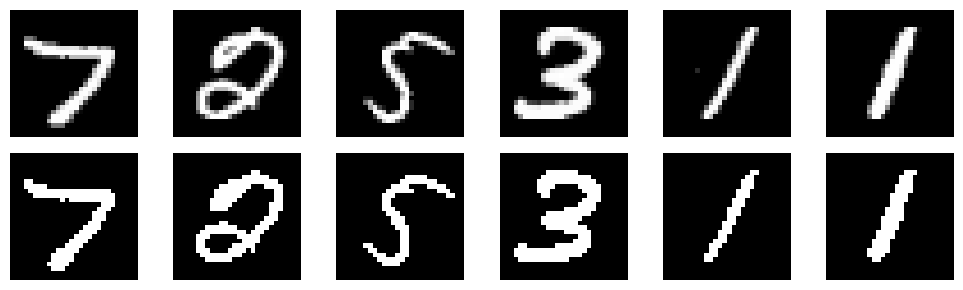

In [23]:
idx = np.random.default_rng(SEED).choice(len(X_train_seg), 6, replace=False)

plt.figure(figsize=(10, 3))
for i, k in enumerate(idx, 1):
    plt.subplot(2, 6, i)
    plt.imshow(X_train_01[k], cmap="gray")
    plt.axis("off")
    if i == 1:
        plt.ylabel("Orig")

for i, k in enumerate(idx, 1):
    plt.subplot(2, 6, 6 + i)
    plt.imshow(X_train_seg[k], cmap="gray")
    plt.axis("off")
    if i == 1:
        plt.ylabel("Seg")

plt.tight_layout()
plt.show()

Визуально сравниваем оригинальные изображения и их сегментированные версии, чтобы убедиться в корректности предобработки перед обучением модели.

In [25]:
y_train_bin = (y_train == 4).astype(np.int64)
y_test_bin = (y_test == 4).astype(np.int64)

y_train_bin.sum(), y_test_bin.sum(), y_train_bin.mean(), y_test_bin.mean()

(687, 295, 0.09814285714285714, 0.09833333333333333)

Создаём бинарные метки. 1 для цифры 4, 0 для остальных.

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_seg,
    y_train_bin,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_bin,
)

X_tr.shape, X_val.shape

((5950, 28, 28), (1050, 28, 28))

Дополнительно делим training на train и val, чтобы,	выбрать лучший чекпоинт модели, подобрать порог классификации по F1. Без валидации подбор порога по тесту был бы “утечкой данных” и нарушением корректной оценки.

In [29]:
class DigitsDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int):
        return self.X[idx], self.y[idx]

Реализуем кастомный Dataset, который преобразует numpy-данные в формат, совместимый с PyTorch CNN, и позволяет DataLoader формировать батчи для обучения.

In [31]:
train_ds = DigitsDataset(X_tr, y_tr)
val_ds = DigitsDataset(X_val, y_val)
test_ds = DigitsDataset(X_test_seg, y_test_bin)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False)

Задаём batch_size. 128 для train - баланс скорости и стабильности градиента,256 для val,test.

In [33]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

device

device(type='mps')

Выбор устройства если есть используем cuda, если на macOS MPS, если нет то просто cpu.

In [35]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(128, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = self.drop(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        x = self.fc(x)
        return x

В качестве бейзлайн модели была выбрана нейросеть (CNN) для бинарной классификации.

Архитектура имеет 3 сверточных слоя с увеличением числа каналов 1,32,64,128, что позволяет постепенно извлекать признаки разной сложности: от простых линий и границ до более сложных форм цифры 4.

Использование Batch Normalization стабилизирует обучение и ускоряет сходимость. Dropout (0.3) добавлен для снижения риска переобучения.

Применение Adaptive Average Pooling позволяет уменьшить количество параметров перед финальным линейным слоем и делает архитектуру более устойчивой, чем использование большого fully connected слоя.

Модель достаточно хорошо работает для MNIST, но при этом она компактная и вычислительно эффективная, что делает её разумным бейзлайн перед использованием более сложных архитектур.

In [37]:
def collect_probs(model: nn.Module, loader: DataLoader, device: torch.device):
    model.eval()
    probs = []
    ys = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            p = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
            probs.append(p)
            ys.append(yb.numpy().reshape(-1))
    return np.concatenate(probs), np.concatenate(ys)

Функция используется для получения вероятностей предсказаний модели на валидационной и тестовой выборках. Она переводит модель в режим оценки, отключает вычисление градиентов и собирает вероятности класса 4 вместе с истинными метками. Это необходимо для корректного расчёта метрик (ROC-AUC, PR-кривая, F1) и подбора оптимального порога классификации.

In [39]:
model = SmallCNN().to(device)

pos = int(y_tr.sum())
neg = int(len(y_tr) - pos)
pos_weight = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=12)

best_auc = 0.0
best_state = None
patience = 4
bad_epochs = 0

for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad(set_to_none=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += float(loss.item())
    scheduler.step()

    val_probs, val_y = collect_probs(model, val_loader, device)
    val_auc = roc_auc_score(val_y, val_probs)
    print(f"Epoch {epoch} | Loss {total_loss:.4f} | Val ROC-AUC {val_auc:.5f}")

    if val_auc > best_auc + 1e-4:
        best_auc = val_auc
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping")
            break

model.load_state_dict(best_state)
best_auc

Epoch 1 | Loss 44.7479 | Val ROC-AUC 0.93517
Epoch 2 | Loss 29.6678 | Val ROC-AUC 0.97899
Epoch 3 | Loss 20.0440 | Val ROC-AUC 0.99075
Epoch 4 | Loss 15.2866 | Val ROC-AUC 0.99214
Epoch 5 | Loss 12.3824 | Val ROC-AUC 0.99441
Epoch 6 | Loss 10.1927 | Val ROC-AUC 0.99253
Epoch 7 | Loss 9.0299 | Val ROC-AUC 0.99603
Epoch 8 | Loss 8.7067 | Val ROC-AUC 0.99569
Epoch 9 | Loss 7.5563 | Val ROC-AUC 0.99596
Epoch 10 | Loss 6.9420 | Val ROC-AUC 0.99613
Epoch 11 | Loss 6.5553 | Val ROC-AUC 0.99651
Epoch 12 | Loss 6.4626 | Val ROC-AUC 0.99655
Epoch 13 | Loss 6.5446 | Val ROC-AUC 0.99653
Epoch 14 | Loss 6.5030 | Val ROC-AUC 0.99655
Epoch 15 | Loss 6.3104 | Val ROC-AUC 0.99655
Early stopping


0.99651428630012

В данном блоке просиходит обучение модели.

Модель инициализируется и переносится на выбранное устройство CPU или GPU. Поскольку класс 4 составляет около 9–10% выборки, используется pos_weight в BCEWithLogitsLoss для компенсации дисбаланса классов, ошибки на положительном классе штрафуются сильнее. 

В качестве оптимизатора выбран AdamW (lr=1e-3, weight_decay=1e-4), который обеспечивает стабильную сходимость и регуляризацию весов. Дополнительно применяется scheduler CosineAnnealingLR для плавного уменьшения learning rate.

Обучение проводится до 20 эпох с ранней остановкой (early stopping) по метрике ROC-AUC на валидационной выборке. Лучшая версия модели сохраняется и загружается после завершения обучения.

Мы видим значительное уменешение loss ,затем срабатывает early stopping и мы сохраняем лучшую версию модели.

In [41]:
val_probs, val_y = collect_probs(model, val_loader, device)

thresholds = np.linspace(0.05, 0.95, 181)
best_t = 0.5
best_f1 = -1.0
for t in thresholds:
    pred = (val_probs >= t).astype(int)
    f = f1_score(val_y, pred, zero_division=0)
    if f > best_f1:
        best_f1 = f
        best_t = float(t)

test_probs, test_y = collect_probs(model, test_loader, device)
test_pred = (test_probs >= best_t).astype(int)

acc = accuracy_score(test_y, test_pred)
prec = precision_score(test_y, test_pred, zero_division=0)
rec = recall_score(test_y, test_pred, zero_division=0)
f1 = f1_score(test_y, test_pred, zero_division=0)
auc = roc_auc_score(test_y, test_probs)

print(f"Best Val ROC-AUC: {best_auc:.5f}")
print(f"Chosen threshold (by Val F1): {best_t:.3f} | Val F1: {best_f1:.4f}")
print(f"Test Accuracy:  {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall:    {rec:.4f}")
print(f"Test F1-score:  {f1:.4f}")
print(f"Test ROC-AUC:   {auc:.5f}")

Best Val ROC-AUC: 0.99651
Chosen threshold (by Val F1): 0.630 | Val F1: 0.9429
Test Accuracy:  0.9873
Test Precision: 0.9079
Test Recall:    0.9695
Test F1-score:  0.9377
Test ROC-AUC:   0.99621


На валидационной выборке собираются вероятности предсказаний модели.

Перебираются различные пороги классификации (от 0.05 до 0.95).

Для каждого порога считается F1-score.

Выбирается порог, при котором F1 максимален.
 
Этот оптимальный порог применяется к тестовой выборке.
 
Рассчитываются метрики: Accuracy, Precision, Recall, F1-score и ROC-AUC.

Таким образом, модель оценивается не с фиксированным порогом 0.5, а с оптимальным порогом, найденным на валидации.

Best threshold = 0.63
Это означает, что изображение считается 4, если вероятность ≥ 63%.

Метрики:

Accuracy = 0.9873

Общая доля правильных предсказаний высокая, но при дисбалансе классов эта метрика может быть завышена.

Precision = 0.9079

Около 91% предсказанных 4 действительно являются 4.

Recall = 0.9695

Модель находит почти 97% всех настоящих 4, то есть почти не пропускает нужные объекты.

F1-score = 0.9377

Хороший баланс между Precision и Recall. Подходит как основная метрика для задачи.

ROC-AUC = 0.99621

Модель практически идеально ранжирует вероятности класса 4.

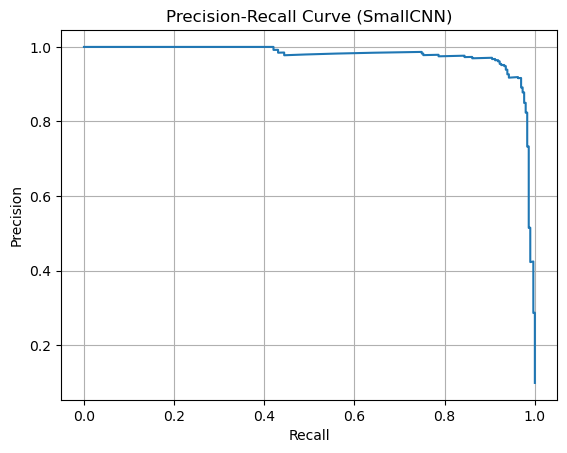

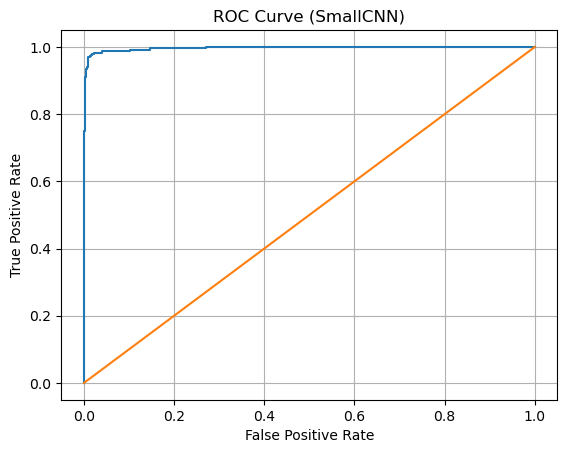

In [43]:
p, r, _ = precision_recall_curve(test_y, test_probs)
fpr, tpr, _ = roc_curve(test_y, test_probs)

plt.figure()
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (SmallCNN)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (SmallCNN)")
plt.grid(True)
plt.show()

Строим Precision–Recall и ROC-кривые на тестовой выборке, используя вероятности предсказаний модели. Это позволяет оценить качество модели при разных порогах классификации, а не только при фиксированном значении.

PR-кривая находится высоко почти на всём диапазоне recall, что означает, что при поиске цифры 4 модель сохраняет высокий precision при большой полноте. Резкое падение precision при recall = 1 показывает, что если пытаться найти абсолютно все 4, начнут резко расти ложные положительные ответы.

ROC-кривая почти прижата к левому верхнему углу, а ROC-AUC = 0.996 говорит о почти идеальной способности модели отделять 4 от остальных цифр. Линия значительно выше диагонали случайного классификатора, значит модель существенно лучше случайного угадывания.

В целом графики подтверждают, что SmallCNN качественно разделяет классы и даёт очень высокое качество обнаружения цифры 4.

In [47]:
X_tr_g, X_val_g, y_tr_g, y_val_g = train_test_split(
    X_train_01,
    y_train_bin,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_bin,
)

train_ds_g = DigitsDataset(X_tr_g, y_tr_g)
val_ds_g = DigitsDataset(X_val_g, y_val_g)
test_ds_g = DigitsDataset(X_test_01, y_test_bin)

train_loader_g = DataLoader(train_ds_g, batch_size=128, shuffle=True)
val_loader_g = DataLoader(val_ds_g, batch_size=256, shuffle=False)
test_loader_g = DataLoader(test_ds_g, batch_size=256, shuffle=False)

Подготовка данных для другой модели.

In [49]:
class ResNet18Binary(nn.Module):
    def __init__(self):
        super().__init__()
        m = resnet18(weights=None)
        m.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        m.fc = nn.Linear(m.fc.in_features, 1)
        self.m = m

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.m(x)

Этот класс реализует модифицированную версию ResNet18 для бинарной классификации. Базовая архитектура ResNet18 используется без предобученных весов, после чего первый сверточный слой адаптируется под одноканальные (grayscale) изображения вместо стандартных 3-x каналов. Финальный полносвязный слой заменяется на слой с одним выходом, так как задача — бинарная классификация). Таким образом, модель сохраняет преимущества глубокой residual-архитектуры, но адаптирована под конкретную задачу и формат данных.

In [51]:
resnet = ResNet18Binary().to(device)

pos = int(y_tr_g.sum())
neg = int(len(y_tr_g) - pos)
pos_weight_r = torch.tensor([neg / max(pos, 1)], dtype=torch.float32, device=device)

criterion_r = nn.BCEWithLogitsLoss(pos_weight=pos_weight_r)
optimizer_r = torch.optim.AdamW(resnet.parameters(), lr=5e-4, weight_decay=1e-4)
scheduler_r = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_r, T_max=10)

best_auc_r = 0.0
best_state_r = None
patience = 4
bad_epochs = 0

for epoch in range(1, 21):
    resnet.train()
    total_loss = 0.0
    for xb, yb in train_loader_g:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer_r.zero_grad(set_to_none=True)
        logits = resnet(xb)
        loss = criterion_r(logits, yb)
        loss.backward()
        optimizer_r.step()
        total_loss += float(loss.item())
    scheduler_r.step()

    val_probs_r, val_y_r = collect_probs(resnet, val_loader_g, device)
    val_auc_r = roc_auc_score(val_y_r, val_probs_r)
    print(f"Epoch {epoch} | Loss {total_loss:.4f} | Val ROC-AUC {val_auc_r:.5f}")

    if val_auc_r > best_auc_r + 1e-4:
        best_auc_r = val_auc_r
        best_state_r = {k: v.detach().cpu().clone() for k, v in resnet.state_dict().items()}
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early stopping")
            break

resnet.load_state_dict(best_state_r)
best_auc_r

Epoch 1 | Loss 13.0516 | Val ROC-AUC 0.99708
Epoch 2 | Loss 2.7751 | Val ROC-AUC 0.99960
Epoch 3 | Loss 0.9925 | Val ROC-AUC 0.99549
Epoch 4 | Loss 0.7545 | Val ROC-AUC 0.99582
Epoch 5 | Loss 0.8942 | Val ROC-AUC 0.99915
Epoch 6 | Loss 0.3830 | Val ROC-AUC 0.99733
Early stopping


0.9996001681344255

Проводим обучение модели ResNet18 и выбора лучшего чекпоинта по качеству на валидации.

Создаём ResNet18 и переносим на device.

Из-за дисбаланса классов считаем pos_weight и используем BCEWithLogitsLoss , чтобы модель сильнее наказывалась за пропуски цифры 4.

AdamW — стабильная и быстрая сходимость, встроенная регуляризация через weight decay.

CosineAnnealingLR — плавное уменьшение learning rate.

Испозуем early stoppping чтобы избежать переобучения.

В конце загружаем лучший сохранённый чекпоинт и возвращаем best_auc_r — лучшую ROC-AUC на валидации.

Уже на 6 эпохе срабатывает early stopping

Val ROC-AUC ≈ 0.9996, показывает почти идеальное отделение цифры 4 от остальных классов

In [55]:
val_probs_r, val_y_r = collect_probs(resnet, val_loader_g, device)

thresholds = np.linspace(0.05, 0.95, 181)
best_t_r = 0.5
best_f1_r = -1.0
for t in thresholds:
    pred = (val_probs_r >= t).astype(int)
    f = f1_score(val_y_r, pred, zero_division=0)
    if f > best_f1_r:
        best_f1_r = f
        best_t_r = float(t)

test_probs_r, test_y_r = collect_probs(resnet, test_loader_g, device)
test_pred_r = (test_probs_r >= best_t_r).astype(int)

acc_r = accuracy_score(test_y_r, test_pred_r)
prec_r = precision_score(test_y_r, test_pred_r, zero_division=0)
rec_r = recall_score(test_y_r, test_pred_r, zero_division=0)
f1_r = f1_score(test_y_r, test_pred_r, zero_division=0)
auc_r = roc_auc_score(test_y_r, test_probs_r)

print(f"Best Val ROC-AUC (ResNet18): {best_auc_r:.5f}")
print(f"Chosen threshold (by Val F1): {best_t_r:.3f} | Val F1: {best_f1_r:.4f}")
print(f"Test Accuracy:  {acc_r:.4f}")
print(f"Test Precision: {prec_r:.4f}")
print(f"Test Recall:    {rec_r:.4f}")
print(f"Test F1-score:  {f1_r:.4f}")
print(f"Test ROC-AUC:   {auc_r:.5f}")

Best Val ROC-AUC (ResNet18): 0.99960
Chosen threshold (by Val F1): 0.930 | Val F1: 0.9615
Test Accuracy:  0.9913
Test Precision: 0.9439
Test Recall:    0.9695
Test F1-score:  0.9565
Test ROC-AUC:   0.99920


Код подбирает лучший порог классификации на валидации по максимальному F1-score (перебор порогов 0.05–0.95), затем применяет этот порог к тестовой выборке и считает метрики. Для ResNet18 выбран высокий порог 0.93, значит модель требует высокой уверенности, прежде чем сказать 4, что обычно снижает ложные срабатывания и улучшает баланс Precision,Recall.

Результаты на тесте: Accuracy 0.9913, Precision 0.9439, Recall 0.9695, F1 0.9565, ROC-AUC 0.9992. Это означает, что модель почти идеально разделяет классы (ROC-AUC-1), находит почти все настоящие 4 (Recall=0.97) и при этом редко ошибочно помечает другие цифры как 4 (Precision-0.94). В целом качество очень высокое, и F1=0.956 показывает сильный итоговый баланс для задачи с дисбалансом классов.

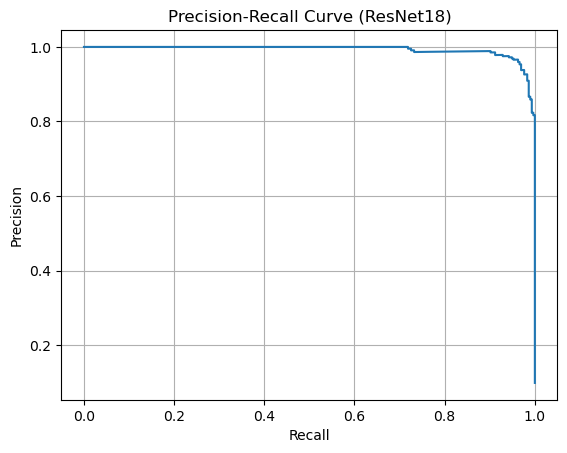

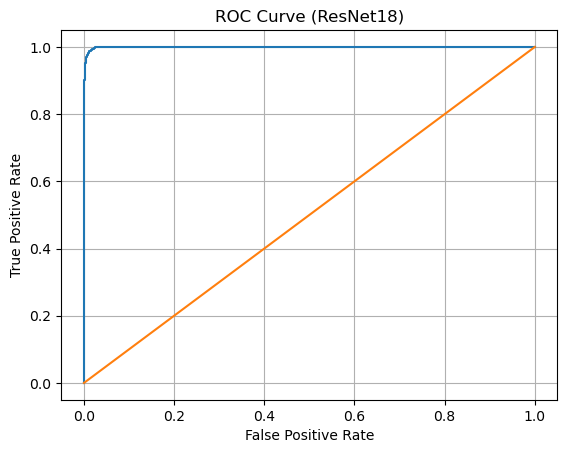

In [57]:
p_r, r_r, _ = precision_recall_curve(test_y_r, test_probs_r)
fpr_r, tpr_r, _ = roc_curve(test_y_r, test_probs_r)

plt.figure()
plt.plot(r_r, p_r)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (ResNet18)")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(fpr_r, tpr_r)
plt.plot([0, 1], [0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet18)")
plt.grid(True)
plt.show()

Строим Precision–Recall и ROC-кривые на тестовой выборке, используя вероятности предсказаний модели. Это позволяет оценить качество модели при разных порогах классификации, а не только при фиксированном значении.

Краткое объяснение результатов по графикам ResNet18:

Precision-Recall кривая почти прижата к верхней границе . Это означает, что модель находит почти все 4 и при этом делает очень мало ложных срабатываний. Резкое падение Precision происходит только при экстремально низком пороге, когда модель начинает классифицировать почти всё как 4.

ROC-кривая практически проходит вдоль левого и верхнего края, а ROC-AUC = 0.999. Это говорит о почти идеальном разделении классов — модель очень хорошо ранжирует вероятности.


In [59]:
df_compare = pd.DataFrame(
    [
        {"model": "SmallCNN(segmented)", "acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc_auc": auc},
        {"model": "ResNet18(grayscale)", "acc": acc_r, "prec": prec_r, "rec": rec_r, "f1": f1_r, "roc_auc": auc_r},
    ]
)

df_compare

,model,acc,prec,rec,f1,roc_auc
0,SmallCNN(segmented),0.987333,0.907937,0.969492,0.937705,0.996210
1,ResNet18(grayscale),0.991333,0.943894,0.969492,0.956522,0.999195


По таблице можно увидеть что ResNet18 превосходит SmallCNN по всем ключевым метрикам. Главное отличие ResNet18 лучше балансирует Precision и Recall, поэтому итоговый F1 выше. Это подтверждает, что более глубокая residual-архитектура лучше извлекает признаки и даёт более устойчивое разделение классов.

Итог: для продакшена логично выбрать ResNet18 как более качественную модель.